In [10]:
import pandas as pd
import numpy as np
from nltk.classify import MaxentClassifier
from nltk.classify.util import accuracy
from itertools import combinations

In [11]:
file_path = "C:/Users/user/Downloads/100k.csv"
df = pd.read_csv(file_path)

C:\Users\user\AppData\Local\Temp\ipykernel_9136\193474783.py:2: DtypeWarning: Columns (29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [12]:
pos_weights = {
    'ADJ': 5,
    'ADV': 4,
    'VERB': 3,
    'NOUN': 2,
    'PRON': 1,
    'PROPN': 1,
    'ADP': 1,
    'CCONJ': 1,
    'INTJ': 1,
    'SCONJ': 1,
    'AUX': 1
}

In [ ]:
available_pos = [col for col in df.columns if col.startswith('pos_')]

unique_pos_tags = set()
for col in available_pos:
    unique_pos_tags.update(df[col].dropna().unique())

def filter_and_shift(row, tag_subset):
    filtered = [tag if tag in tag_subset else np.nan for tag in row[available_pos].values]
    non_nan = [tag for tag in filtered if pd.notna(tag)]
    shifted = non_nan + [np.nan] * (len(filtered) - len(non_nan))
    return shifted

def assign_pos_weights_shifted(pos_tags):
    return [pos_weights.get(tag, 1) if pd.notna(tag) else 0 for tag in pos_tags]

def format_features(weights):
    return {f'feature_{i}': w for i, w in enumerate(weights)}

all_results = []

selected_tags = list(pos_weights.keys())

In [ ]:
from random import shuffle
shuffled_labels = df['Sentiment'].tolist()
shuffle(shuffled_labels)
df['shuffled_label'] = shuffled_labels


In [16]:
print(df['Sentiment'].value_counts())


Sentiment
negative    50000
positive    50000
Name: count, dtype: int64


In [ ]:
for subset_size in range(7, len(selected_tags) + 1):
    print(f"\n--- Subset Size: {subset_size} ---")

    for combi in combinations(selected_tags, subset_size):
        tag_subset = list(combi)

        df['shifted_tags'] = df.apply(lambda row: filter_and_shift(row, tag_subset), axis=1)

        # Apply weights
        df['weights'] = df['shifted_tags'].apply(assign_pos_weights_shifted)
        df['features'] = df['weights'].apply(format_features)

        df['mean_weight'] = df['weights'].apply(np.mean)
        threshold = df['mean_weight'].median()
        df['label'] = df['mean_weight'].apply(lambda x: 'positive' if x > threshold else 'negative')

        # Train
        # test split
        data = list(zip(df['features'], df['label']))
        split_index = int(0.8 * len(data))
        train_data = data[:split_index]
        test_data = data[split_index:]

        if len(test_data) < 20:
            print(f"Skipping {combi} due to small test set.")
            continue

        try:
            classifier = MaxentClassifier.train(train_data, algorithm='GIS', max_iter=5, trace=0)
            acc = accuracy(classifier, test_data)

            print(f"POS tags: {combi} -> Accuracy: {acc:.4f}")
            all_results.append({
                'subset_size': subset_size,
                'combination': combi,
                'accuracy': acc
            })
        except Exception as e:
            print(f"Error training on {combi}: {e}")

sorted_results = sorted(all_results, key=lambda x: x['accuracy'], reverse=True)
print("\nTop 10 combinations:")
for i, res in enumerate(sorted_results[:10], 1):
    print(f"{i}. POS tags: {res['combination']} -> Accuracy: {res['accuracy']:.4f}")


--- Subset Size: 7 ---
POS tags: ('ADJ', 'ADV', 'VERB', 'NOUN', 'PRON', 'PROPN', 'ADP') -> Accuracy: 0.9029
POS tags: ('ADJ', 'ADV', 'VERB', 'NOUN', 'PRON', 'PROPN', 'CCONJ') -> Accuracy: 0.9033
POS tags: ('ADJ', 'ADV', 'VERB', 'NOUN', 'PRON', 'PROPN', 'INTJ') -> Accuracy: 0.9020
POS tags: ('ADJ', 'ADV', 'VERB', 'NOUN', 'PRON', 'PROPN', 'SCONJ') -> Accuracy: 0.9021
POS tags: ('ADJ', 'ADV', 'VERB', 'NOUN', 'PRON', 'PROPN', 'AUX') -> Accuracy: 0.8996
POS tags: ('ADJ', 'ADV', 'VERB', 'NOUN', 'PRON', 'ADP', 'CCONJ') -> Accuracy: 0.9163
POS tags: ('ADJ', 'ADV', 'VERB', 'NOUN', 'PRON', 'ADP', 'INTJ') -> Accuracy: 0.9145
POS tags: ('ADJ', 'ADV', 'VERB', 'NOUN', 'PRON', 'ADP', 'SCONJ') -> Accuracy: 0.9080
POS tags: ('ADJ', 'ADV', 'VERB', 'NOUN', 'PRON', 'ADP', 'AUX') -> Accuracy: 0.9050
POS tags: ('ADJ', 'ADV', 'VERB', 'NOUN', 'PRON', 'CCONJ', 'INTJ') -> Accuracy: 0.9084
POS tags: ('ADJ', 'ADV', 'VERB', 'NOUN', 'PRON', 'CCONJ', 'SCONJ') -> Accuracy: 0.9085
POS tags: ('ADJ', 'ADV', 'VERB', 'NO

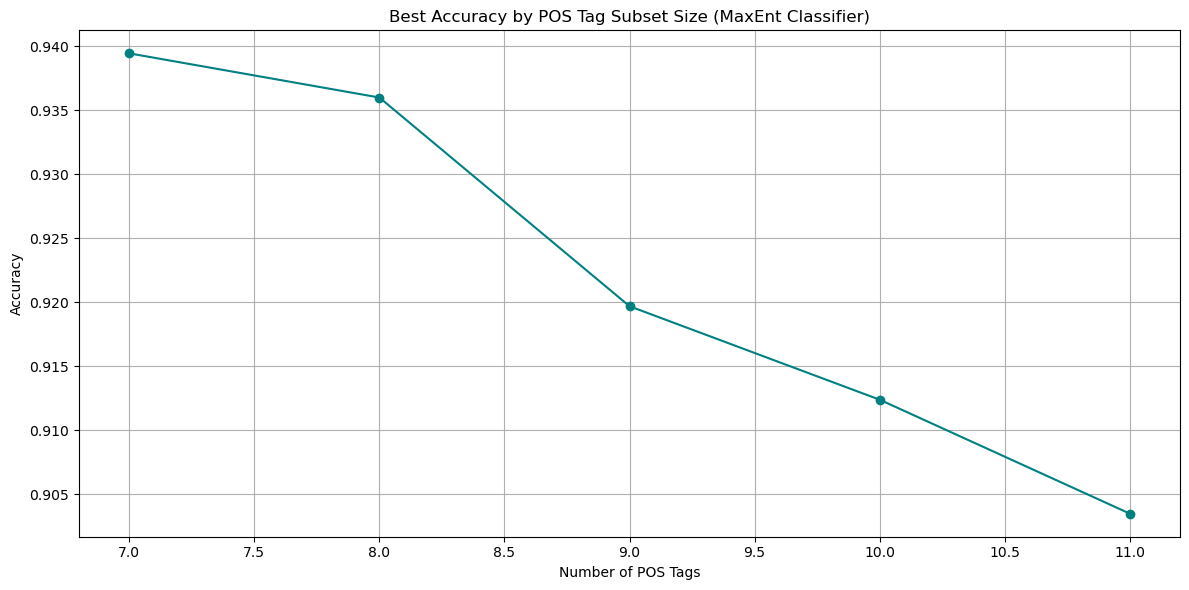

In [18]:
import matplotlib.pyplot as plt

# Extract best accuracy per subset size
best_accuracies = {}
for result in all_results:
    size = result['subset_size']
    acc = result['accuracy']
    if size not in best_accuracies or acc > best_accuracies[size]:
        best_accuracies[size] = acc

# Sort by subset size
sorted_sizes = sorted(best_accuracies.keys())
accuracies = [best_accuracies[size] for size in sorted_sizes]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(sorted_sizes, accuracies, marker='o', color='teal')
plt.xlabel("Number of POS Tags")
plt.ylabel("Accuracy")
plt.title("Best Accuracy by POS Tag Subset Size (MaxEnt Classifier)")
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


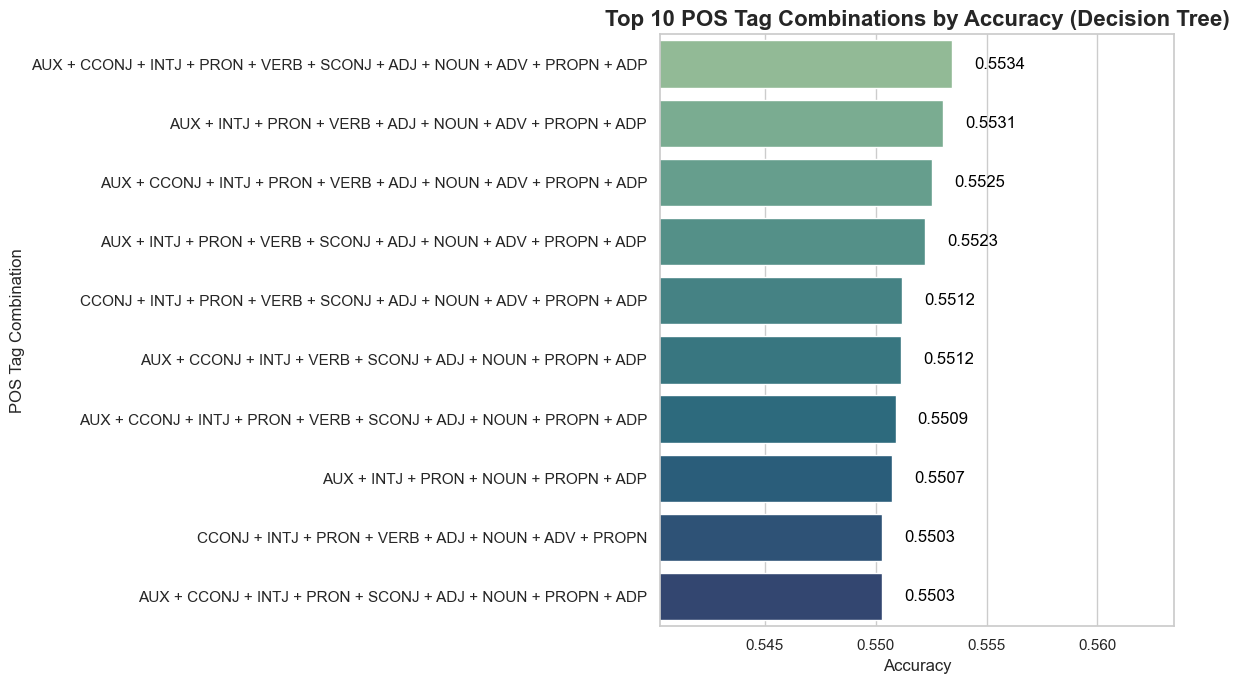

In [18]:
import seaborn as sns

# Prepare data
top_10 = sorted_results[:10]
tags = [' + '.join(tags) for _, tags, _ in top_10]
accuracies = [acc for _, _, acc in top_10]

# Style
sns.set(style="whitegrid")
palette = sns.color_palette("crest", len(tags))

# Plot
plt.figure(figsize=(12, 7))
barplot = sns.barplot(x=accuracies, y=tags, palette=palette)

# Annotate bars
for i, (acc, tag) in enumerate(zip(accuracies, tags)):
    barplot.text(acc + 0.001, i, f"{acc:.4f}", color='black', va='center')

# Titles and labels
plt.title("Top 10 POS Tag Combinations by Accuracy (Decision Tree)", fontsize=16, weight='bold')
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("POS Tag Combination", fontsize=12)
plt.xlim(min(accuracies) - 0.01, max(accuracies) + 0.01)
plt.tight_layout()
plt.show()